In [1]:
!pip install tensorboardcolab

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-cp37-none-any.whl size=3860 sha256=f20b062bee0149a8973957370357de9f7797c2bd9765025c138ae843f4535665
  Stored in directory: /root/.cache/pip/wheels/c4/aa/a0/3aaf4f1a66adbdab9b7bdd4c96db8ada89eb7cd87200cfdd32
Successfully built tensorboardcolab


In [2]:
import torch as T
import torchvision as tv
import torchvision.transforms as tvt
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as opt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf
import datetime
import PIL
import tensorboardcolab as tb
import io

In [3]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")

In [4]:
%load_ext tensorboard
# add log delete

In [5]:
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [6]:
trans = tvt.Compose([tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), 
                                                   (0.5, 0.5, 0.5))])

In [7]:
# os.listdir('./data/cifar-10-batches-py/')

In [8]:
train = tv.datasets.CIFAR10(root='./data', train=True, 
                          download=True, transform=trans)
trainloader = T.utils.data.DataLoader(train, batch_size=256, 
                                      shuffle=True, num_workers=4)
test = tv.datasets.CIFAR10(root='./data', train=False, 
                           download=True, transform=trans)
testloader = T.utils.data.DataLoader(test, batch_size=256, 
                                     shuffle=False, num_workers=4)


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [9]:
for data in testloader:
    ima, la = data
    print(ima[0].shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 32, 32])


In [10]:
cls = ['plane', 'car', 'bird', 'cat', 'deer', 
       'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
class NeutralNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(NeutralNet, self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(3, 64)
        )
    def forward(self, x):
        
        return x


In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layers = nn.Sequential(
        nn.Dropout(0.6),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.6),
        nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        conv_features = self.features(x)
        flatten = conv_features.view(conv_features.size(0), -1)
        fc = self.fc_layers(flatten)
        return fc


In [13]:
conv_netw = AlexNet().to(device)

In [14]:
loss = nn.CrossEntropyLoss()
op = opt.SGD(conv_netw.parameters(), lr=0.01, momentum=0.9)
batch_size = 256

In [15]:
epochs = [k for k in range(1)]
acc_list = []
for epoch in range(1):
    epoch_loss = 0
    counter = 0
    conv_netw.train()
    for data in tqdm(trainloader):
        inps, labs = data
        inps = inps.to(device)
        labs = labs.to(device)
        op.zero_grad()
        out = conv_netw(inps)
        losses = loss(out, labs)
        losses.backward()
        op.step()
        counter
        epoch_loss += losses/batch_size
    print("\nEpoch loss:", epoch_loss.item())
    #if epoch % 1 == 0:
    correct = 0.0
    total = 0.0
    with T.no_grad():
      conv_netw.eval()
      for data in testloader:
          images, labels = data
          labels = labels.to(device)
          images = images.to(device)
          outputs = conv_netw(images)
          _, predicted = T.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      accur = 100 * correct / total
      acc_list.append(accur)
      print(accur)
        # tf.summary.scalar('loss', loss.item(), step=epoch)
        # tf.summary.scalar('accuracy', accur, step=epoch)
        #print('epoch: %d, accuracy: %d %%' % 
        #      (epoch + 1, (100 * correct / total)))
        #acc_list.append(100 * correct / total)
        #plt.figure(figsize=(10, 10))
        #plt.plot([(k * 5) for k in range(1, len(acc_list) + 1)], acc_list)
        #plt.show()
        #if (len(acc_list) >= 3 and
        #   acc_list[len(acc_list) - 1] == acc_list[len(acc_list) - 2] and
        #   acc_list[len(acc_list) - 2] == acc_list[len(acc_list) - 3]):
        #   break


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 196/196 [00:18<00:00, 10.75it/s]


Epoch loss: 1.7374365329742432


24.73


In [16]:
T.save(conv_netw.state_dict(), './trained.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


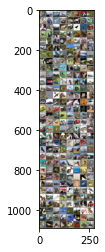

predict:    cat  ship  ship plane


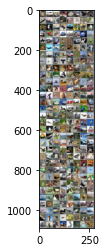

predict:    cat plane plane truck


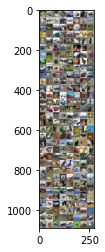

predict:   frog   car   dog   cat


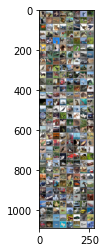

predict:    dog  deer  frog   car


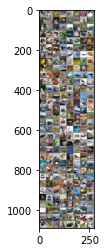

predict:    cat   dog plane plane


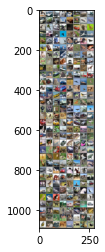

predict:    cat  ship truck   dog


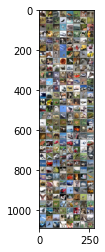

predict:    dog  deer   cat  bird


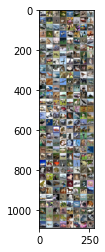

predict:  truck   dog   cat  frog


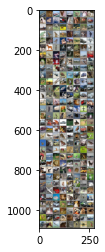

predict:   ship   cat  ship   dog


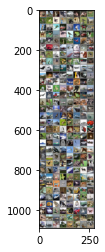

predict:   frog truck   cat truck


In [17]:
def printimg(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(testloader)
for _ in range(10):
    imgs, labels = data_iter.next()
    printimg(tv.utils.make_grid(imgs))
    print('predict: ', ' '.join('%5s' % cls[labels[j]] for j in range(4)))

In [18]:
correct = 0
total = 0
with T.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = conv_netw(images)
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 24 %


In [19]:
!rm -rf logs/plots

logdir = "logs/plots/"
file_writer = tf.summary.create_file_writer(logdir)

def plot_to_image(figure):
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=3)
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  figure = plt.figure(figsize=(10,10))
  ite = iter(trainloader)
  imgs, pred = ite.next()
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imgs[i] = tv.utils.make_grid(imgs[i])
    imgs[i] = imgs[i] / 2 + 0.5
    npimg = imgs[i].numpy()
    print(plot_to_image(imgs[i]).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=plt.cm.binary)
  return figure

figure = image_grid()
with file_writer.as_default():
  tf.summary.image("Training data", plot_to_image(figure), step=0)

#%tensorboard --logdir logs/plots

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)
(1, 720, 720, 3)


In [20]:
logdir = "logs/train_data/"
file_writer = tf.summary.create_file_writer(logdir)

In [21]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    #image = tf.expand_dims(image, 0)
    return image

for data in testloader:
    images, labels = data
    #img = np.reshape(images[0:256], (-1, 32, 32, 3))
    tensored_images = []
    for i in range(len(images)):
        figure = plt.figure(figsize=(32, 32))
        images[i] = images[i] / 2 + 0.5
        npimg = images[i].numpy()
        plt.title(labels[i])
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        r = patches.Rectangle((3, 3), 10, 10)
        ax = plt.gca()
        ax.add_patch(r)
        tensored_images.append(plot_to_image(figure))
        break

    with file_writer.as_default():
        tf.summary.image("256 test data examples", tensored_images, max_outputs=256, step=0)
#%tensorboard --logdir logs/train_data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
